# Multimodal Embeddings Alignment

In this tutorial, we will learn how to perform alignment between two modalities: textual description and protein sequence.

Before running this notebook, please make sure that you have the embeddings for each modality.

Otherwise, you can generate the embeddings using the following notebooks:
- tutorial_starkqa_primekg_textual_embeddings_all_minilm.ipynb
- tutorial_starkqa_primekg_textual_embeddings_nomic_embed_text.ipynb
- tutorial_biobridge_primekg_protein_embeddings.ipynb


In [1]:
# Import necessary libraries
import os
import sklearn
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVR

### Load Embeddings

We need to load the embedding data from parquet files.

In [2]:
# Define data location
starkqa_local_dir = "../../../../data/starkqa_primekg/"
biobridge_local_dir = "../../../../data/biobridge_primekg/"

In [3]:
# Load textual embeddings
starkqa_textual_df = pd.read_parquet(os.path.join(starkqa_local_dir, 'starkqaprimekg_nodes_embedded.parquet'), engine='pyarrow')
starkqa_textual_df.rename(columns={'enriched_node': 'description', 'x': 'description_embedded'}, inplace=True)
starkqa_textual_df.head()

,node_id,node_name,node_type,description,description_embedded
0,0,PHYHIP,gene/protein,PHYHIP belongs to gene/protein category. Enabl...,"[-0.06876933, 0.00096770556, -0.0630331, -0.04..."
1,1,GPANK1,gene/protein,GPANK1 belongs to gene/protein category. This ...,"[-0.08932163, 0.031602174, -0.102335155, -0.03..."
2,2,ZRSR2,gene/protein,ZRSR2 belongs to gene/protein category. This g...,"[-0.10059608, -0.020288778, 0.008750704, 0.003..."
3,3,NRF1,gene/protein,NRF1 belongs to gene/protein category. This ge...,"[-0.09837414, -0.02768978, -0.061966445, 0.026..."
4,4,PI4KA,gene/protein,PI4KA belongs to gene/protein category. This g...,"[-0.03965294, -0.0017360917, -0.12756099, -5.2..."


In [4]:
 # Load protein embeddings
biobridge_protein_df = pd.read_parquet(os.path.join(biobridge_local_dir, 'biobridgeprimekg_filtered_sequence_embedded.parquet'), engine='pyarrow')
biobridge_protein_df.drop(columns=['node_id', 'node_source'], inplace=True)
biobridge_protein_df.rename(columns={'node_index': 'node_id'}, inplace=True)
biobridge_protein_df.head()

,node_id,node_type,node_name,sequence,sequence_embedded
0,0,gene/protein,PHYHIP,MELLSTPHSIEINNITCDSFRISWAMEDSDLERVTHYFIDLNKKEN...,"[-0.0907055139541626, -0.07978754490613937, 0...."
1,1,gene/protein,GPANK1,MSRPLLITFTPATDPSDLWKDGQQQPQPEKPESTLDGAAARAFYEA...,"[-0.11766866594552994, -0.18336597084999084, -..."
2,2,gene/protein,ZRSR2,MAAPEKMTFPEKPSHKKYRAALKKEKRKKRRQELARLRDSGLSQKE...,"[-0.24953687191009521, -0.10010954737663269, 0..."
3,3,gene/protein,NRF1,MEEHGVTQTEHMATIEAHAVAQQVQQVHVATYTEHSMLSADEDSPS...,"[0.008047989569604397, 0.08891301602125168, 0...."
4,5,gene/protein,SLC15A1,MGMSKSHSFFGYPLSIFFIVVNEFCERFSYYGMRAILILYFTNFIS...,"[0.06465577334165573, 0.12712723016738892, 0.2..."


In [5]:
# Unified dataframe
multimodal_df = starkqa_textual_df.merge(biobridge_protein_df.drop(columns=['node_name', 'node_type']), on='node_id', how='inner')
multimodal_df.head()

,node_id,node_name,node_type,description,description_embedded,sequence,sequence_embedded
0,0,PHYHIP,gene/protein,PHYHIP belongs to gene/protein category. Enabl...,"[-0.06876933, 0.00096770556, -0.0630331, -0.04...",MELLSTPHSIEINNITCDSFRISWAMEDSDLERVTHYFIDLNKKEN...,"[-0.0907055139541626, -0.07978754490613937, 0...."
1,1,GPANK1,gene/protein,GPANK1 belongs to gene/protein category. This ...,"[-0.08932163, 0.031602174, -0.102335155, -0.03...",MSRPLLITFTPATDPSDLWKDGQQQPQPEKPESTLDGAAARAFYEA...,"[-0.11766866594552994, -0.18336597084999084, -..."
2,2,ZRSR2,gene/protein,ZRSR2 belongs to gene/protein category. This g...,"[-0.10059608, -0.020288778, 0.008750704, 0.003...",MAAPEKMTFPEKPSHKKYRAALKKEKRKKRRQELARLRDSGLSQKE...,"[-0.24953687191009521, -0.10010954737663269, 0..."
3,3,NRF1,gene/protein,NRF1 belongs to gene/protein category. This ge...,"[-0.09837414, -0.02768978, -0.061966445, 0.026...",MEEHGVTQTEHMATIEAHAVAQQVQQVHVATYTEHSMLSADEDSPS...,"[0.008047989569604397, 0.08891301602125168, 0...."
4,5,SLC15A1,gene/protein,SLC15A1 belongs to gene/protein category. This...,"[-0.057222307, -0.053243265, -0.0645301, -0.08...",MGMSKSHSFFGYPLSIFFIVVNEFCERFSYYGMRAILILYFTNFIS...,"[0.06465577334165573, 0.12712723016738892, 0.2..."


In [6]:
# Check number of existing number of records
print(f"Number of records in StarkQA textual embeddings: {len(starkqa_textual_df)}")
print(f"Number of records in Biobridge protein embeddings: {len(biobridge_protein_df)}")
print(f"Number of records in the unified dataframe: {len(multimodal_df)}")

Number of records in StarkQA textual embeddings: 129375
Number of records in Biobridge protein embeddings: 18744
Number of records in the unified dataframe: 18744


In [7]:
# Make a separate list of embeddings for each modality
textual_embeddings = np.array(multimodal_df['description_embedded'].tolist())
protein_embeddings = np.array(multimodal_df['sequence_embedded'].tolist())

In [8]:
# Check the shape of the embeddings
print(f"Shape of textual embeddings: {textual_embeddings.shape}")
print(f"Shape of protein embeddings: {protein_embeddings.shape}")

Shape of textual embeddings: (18744, 384)
Shape of protein embeddings: (18744, 320)


Since the embeddings are of different dimensions and spaces, we need to enforce each pair of embeddings representing a node to be close with each other.

### Principal Component Analysis (PCA)

 For the purpose of checking the similarity between the embeddings, we will use Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings, followed by cosine similarity to check the similarity between the embeddings.

In [9]:
# Apply PCA to reduce the dimensionality of the embeddings
from sklearn.decomposition import PCA

# Define the number of components
n_components = 256

# Apply PCA to the textual embeddings
pca_textual = PCA(n_components=n_components)
pca_textual.fit(textual_embeddings)
textual_embeddings_pca = pca_textual.transform(textual_embeddings)

# Apply PCA to the protein embeddings
pca_protein = PCA(n_components=n_components)
pca_protein.fit(protein_embeddings)
protein_embeddings_pca = pca_protein.transform(protein_embeddings)

In [10]:
# Check the shape of the PCA-transformed embeddings
print(f"Shape of PCA-transformed textual embeddings: {textual_embeddings_pca.shape}")
print(f"Shape of PCA-transformed protein embeddings: {protein_embeddings_pca.shape}")

Shape of PCA-transformed textual embeddings: (18744, 256)
Shape of PCA-transformed protein embeddings: (18744, 256)


In [11]:
# Calculate the cosine similarity between the embeddings
cosine_similarities = cosine_similarity(textual_embeddings_pca, protein_embeddings_pca)
print(f"Shape of cosine similarities: {cosine_similarities.shape}")

Shape of cosine similarities: (18744, 18744)


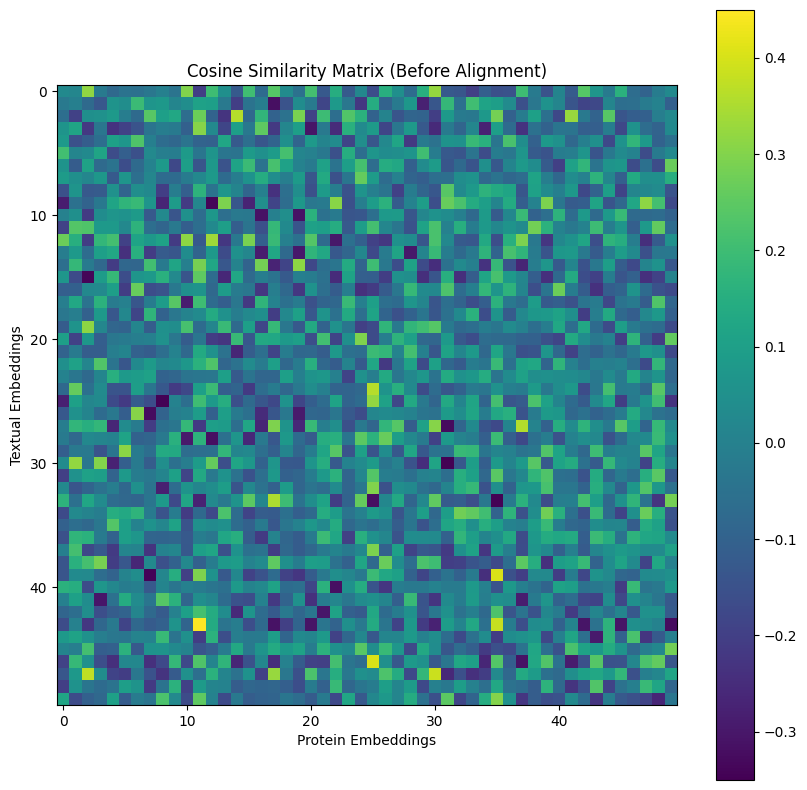

In [12]:
# Visualize the cosine similarities using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cosine_similarities[:50, :50], cmap='viridis', interpolation='nearest') # Display only the first 50 records
plt.colorbar()
plt.title('Cosine Similarity Matrix (Before Alignment)')
plt.ylabel('Textual Embeddings')
plt.xlabel('Protein Embeddings')
plt.show()

### Embeddings Alignment using Linear Regression

We can align the embeddings using a simple method, such as linear regression, as follows:

In [13]:
# Use several samples to align the embeddings
n_samples = int(len(textual_embeddings_pca)*1.0) # Use all samples
text_train = textual_embeddings_pca[:n_samples]
protein_train = protein_embeddings_pca[:n_samples]

# Using linear regression to align the embeddings
linreg = LinearRegression().fit(text_train, protein_train)

# Transform protein embeddings to the text space
predicted_protein = linreg.predict(textual_embeddings_pca)


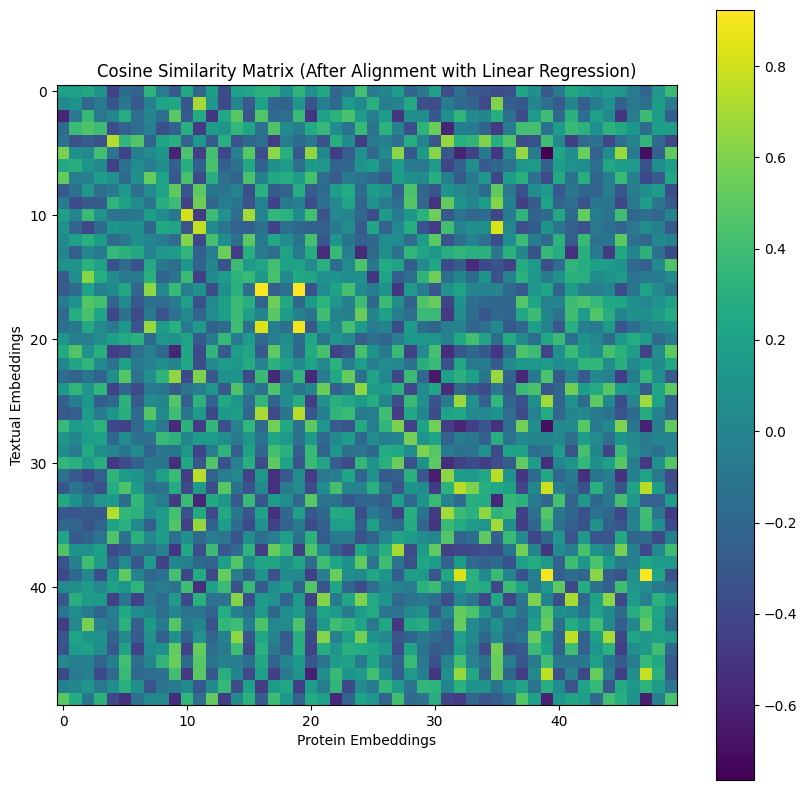

In [14]:
# Calculate the cosine similarity between the embeddings
cosine_similarities = cosine_similarity(predicted_protein, protein_embeddings_pca)

# Visualize the cosine similarities using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cosine_similarities[:50, :50], cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Cosine Similarity Matrix (After Alignment with Linear Regression)')
plt.ylabel('Textual Embeddings')
plt.xlabel('Protein Embeddings')
plt.show()

### Embeddings Alignment using Neural Network

Another alternative is to utilize neural networks that utilize non-linear transformations to align the embeddings. 

Given a text embedding, the mapper will predict the protein embedding.

In [15]:
# Define the model with dropout
class EmbeddingMapper(nn.Module):
    def __init__(self, input_dim, output_dim=256, hidden_dims=[256, 128], dropout_rate=0.5):
        """
        Initialize the embedding mapper model with dropout.
        
        Args:
            input_dim: int, the dimension of the input embeddings.
            output_dim: int, the dimension of the output embeddings.
            hidden_dims: list, the dimensions of the hidden layers.
            dropout_rate: float, the dropout rate.
        """
        super(EmbeddingMapper, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dims[0])
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x) -> torch.Tensor:
        """
        Forward pass of the embedding mapper model with dropout.

        Args :
            x : torch.Tensor, the input embeddings.
        
        Returns:
            torch.Tensor, the output embeddings.
        """
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        
        return x

In [16]:
# Use several samples to align the embeddings
n_samples = int(len(textual_embeddings_pca)*1.0) # Use all samples
text_train = textual_embeddings_pca[:n_samples]
protein_train = protein_embeddings_pca[:n_samples]

# Check device availability
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Define the model
mapper = EmbeddingMapper(input_dim=n_components, 
                         output_dim=n_components, 
                         hidden_dims=[256, 128]).to(device)

# Define the loss function
criterion_mse = nn.MSELoss() 
criterion_mae = nn.L1Loss()

# Define the optimizer
optimizer = torch.optim.Adam(mapper.parameters(), lr=0.0005)

# Convert the embeddings to torch tensors
text_train_tensor = torch.tensor(text_train, dtype=torch.float32).to(device)
protein_train_tensor = torch.tensor(protein_train, dtype=torch.float32).to(device)

# Train the model
n_epochs = 1000
losses = []
for epoch in tqdm(range(n_epochs)):
    # Forward pass
    outputs = mapper(text_train_tensor)
    loss = criterion_mse(outputs, protein_train_tensor) +\
          criterion_mae(outputs, protein_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Print the loss
    losses.append(loss.item())

100%|██████████| 1000/1000 [00:03<00:00, 311.09it/s]


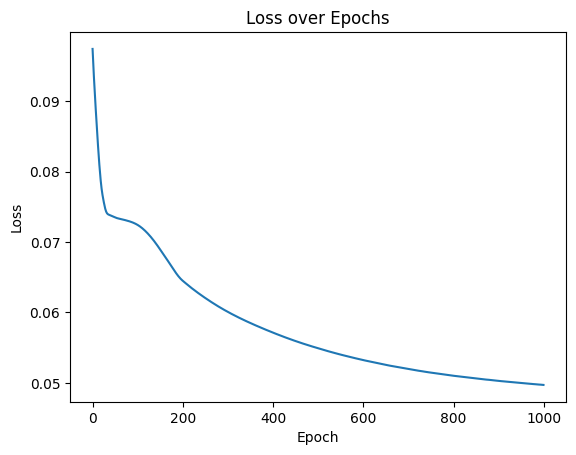

In [17]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

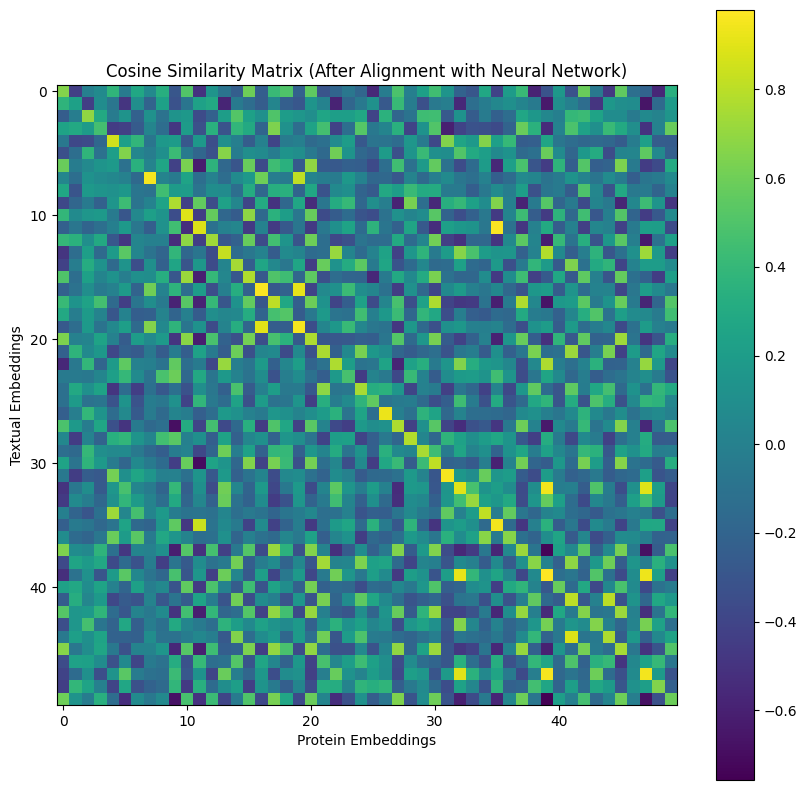

In [18]:
# Transform text embeddings to the protein space
with torch.no_grad():
    predicted_protein = mapper(torch.tensor(textual_embeddings_pca, dtype=torch.float32).to(device))

# Calculate the cosine similarity between the embeddings
cosine_similarities = cosine_similarity(predicted_protein.cpu().numpy(), protein_embeddings_pca)

# Visualize the cosine similarities using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cosine_similarities[:50, :50], cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Cosine Similarity Matrix (After Alignment with Neural Network)')
plt.ylabel('Textual Embeddings')
plt.xlabel('Protein Embeddings')
plt.show()
